# Structure of notebook
1. Basic prophet model on top 50 zipcodes <br>
      * Created a function that would take in a set of ZIP codes and run a basic prophet model 
           on each zipcode and return how well the model did and how much it predicted the house would increase in 5 years<br>
2. How we chose the top 5 <br>
     * The choices we made to chose the top 5 based on the results from the basic prophet function
3. Optimize Parameters for 5 top Zipcodes Using Prophet model and Gridsearch<br>
     * Did a Grid search on the top 5 ZIP codes to optimize prophet model by reducing RMSE
4. Plotted Models
      * Plotted forcast, train, test, predicted. Showed final predicted price, MAPE(mean absolute percentage error)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import ParameterGrid
from numpy import load

In [2]:
# dropping columns that arent needed and using data from 2012 and above 
df = pd.read_csv('../../src/data/zillow_data_lf.csv')
df.time = pd.to_datetime(df.time)
df.drop(['RegionID','SizeRank'], axis = 1, inplace = True)
df = df[pd.DatetimeIndex(df['time']).year >2011]
df.head()

,RegionName,City,State,Metro,CountyName,time,value
2630232,60657,Chicago,IL,Chicago,Cook,2012-01-01,737700.0
2630233,75070,McKinney,TX,Dallas-Fort Worth,Collin,2012-01-01,199600.0
2630234,77494,Katy,TX,Houston,Harris,2012-01-01,248600.0
2630235,60614,Chicago,IL,Chicago,Cook,2012-01-01,928900.0
2630236,79936,El Paso,TX,El Paso,El Paso,2012-01-01,112400.0


# Modeling with prophet

In [30]:
def Prophet_func2(df, zipcodes, period, size_train):
    '''
    Used to determine how well a list of zipcodes will perform and forecast on a basic prophet model
    
    Parameters:
    df - Dataframe with time and value column in long format
    zipcodes - list of zipcodes that are in the dataframe. 
    period - how long into the future you want the to forecast in monthes ex: 60
    size_train - how large the train will be. ex: .8
    
    _____________________________Out Put ________________________________________
    Output:
    a dataframe with columns: Zipcode,Future_Home_Value, Percent_Increase, RMSE ,MAPE 
    
    RMSE = Root mean square error
    MAPE = mean absolute percentage error 
    '''
    
    df_info = pd.DataFrame(dict(Zipcode=[], 
                                 Home_Value=[], 
                                 Future_Home_Value=[], 
                                 Percent_Increase=[],
                                 RMSE = [],
                                 MAPE =[])) 
    for zipcode in zipcodes:
        
       # selecting zipcode from df and changing time and value to ds and y
        data= df[df['RegionName']== zipcode]
        data = data[['time', 'value']]
        data.columns = ['ds','y']
        
        # creating stop index and measuring size of train/test
        eotindex = round(data.shape[0] * size_train)
        train = data[:eotindex]
        test = data[eotindex:]
        train_size = train.shape[0]
        test_size = test.shape[0]
        freq = 'MS'
        
        value_now = int(data.y.tail(1))

        # Prophet Func
        model = Prophet(daily_seasonality= False, weekly_seasonality= False, interval_width=0.95)
        model.fit(train)
        future = model.make_future_dataframe(periods = period + test_size, freq = freq)
        forecast = model.predict(future)

        value_future = round(list(forecast.yhat)[-1],-2)
        diff= value_future - value_now
        rate_5_yrs = 100*(diff / value_now)
        
        y_hat = forecast.yhat[train_size:test_size+train_size]
        root_mse = round(np.sqrt(mean_squared_error(test.y,y_hat)),2)
        mean_ape = round(np.mean(np.abs((np.array(test.y) -  
                           np.array(y_hat))/ np.array(test.y))) * 100, 2) #mean absolute percentage error 
        df_info = df_info.append({'Percent_Increase': rate_5_yrs,
                                  'Home_Value': value_now, 
                                  'Future_Home_Value': value_future,
                                  'Zipcode': zipcode,
                                  'RMSE': root_mse,
                                  'MAPE':mean_ape}, ignore_index = True)
                                    
        
        df_info.Zipcode = df_info.Zipcode.astype('int64')
    return df_info

In [31]:
zipcodes = load('../../src/data/zip_data.npy')
period = 60
size_train = .8

df_zipcodes = Prophet_func2(df, zipcodes, period, size_train)

In [5]:
df_zipcodes.sort_values(by=['MAPE']).reset_index(drop=True).head(10)

,Zipcode,Home_Value,Future_Home_Value,Percent_Increase,RMSE,MAPE
0,37148,157400.0,231400.0,47.013977,530.15,0.32
1,37221,344000.0,472200.0,37.267442,1594.65,0.40
2,37174,282200.0,397100.0,40.715804,1758.04,0.56
3,37115,189800.0,307300.0,61.907271,1283.39,0.70
4,37210,226500.0,421800.0,86.225166,1633.43,0.72
5,37082,227800.0,312900.0,37.357331,1983.67,0.80
6,37015,161700.0,215400.0,33.209647,1587.20,0.80
7,37135,420400.0,588100.0,39.890580,4120.55,0.84
8,37146,217900.0,282000.0,29.417164,2073.36,0.86
9,37190,135200.0,195400.0,44.526627,1271.56,0.90


# Choosing Area Codes

We wanted to narrow down all the zipcodes in Nashville by running a basic prophet model on it and seeing how well the model was by mean absolute percentage error as well as what that model will predict for the housing increase. From above it looked like are codes 37148, 37221, 37174, 37115, 37210 all have high growth and low mean absolute error which is what we want.

# Optimizing Prophet

In [9]:
def optimized_params(df, zipcode, size_train):

    model_parameters = pd.DataFrame(columns = ['RMSE','MAPE','Parameters'])
    
    params_grid = {'seasonality_mode':('multiplicative','additive'),
                   'changepoint_prior_scale':[0.1,0.2,0.3,0.4,0.5],
                   'n_changepoints' : [5,10,20,30]}
    grid = ParameterGrid(params_grid)
    
    data= df[df['RegionName']== zipcode]
    data = data[['time', 'value']]
    data.columns = ['ds','y']

    eotindex = round(data.shape[0] * size_train)
    train = data[:eotindex]
    test = data[eotindex:]

    train_size = train.shape[0]
    test_size = test.shape[0]
    freq = 'MS'
    period = 60

    for p in grid:
    
        # Prophet Func
        model = Prophet(changepoint_prior_scale = p['changepoint_prior_scale'],
                             n_changepoints = p['n_changepoints'],
                             seasonality_mode = p['seasonality_mode'],
                             weekly_seasonality=False,
                             daily_seasonality = False,
                             yearly_seasonality = True,
                             interval_width=0.95)
        model.fit(train)
        future = model.make_future_dataframe(periods = period + test_size, freq = freq)
        forecast = model.predict(future)
        
        y_hat =  forecast.yhat[train_size:test_size+train_size]
        mean_ape = np.mean(np.abs((np.array(test.y) -  
                           np.array(y_hat))/ np.array(test.y))) * 100 #mean absolute percentage error 
        root_mse = np.sqrt(mean_squared_error(test.y,y_hat))


        model_parameters = model_parameters.append({'RMSE':root_mse,'Parameters':p, 'MAPE':mean_ape},ignore_index=True)
        
    param_dic = model_parameters.sort_values(by=['RMSE']).reset_index(drop=True)['Parameters'][0]
    return param_dic, model_parameters

In [10]:
best_zipcodes = [37148, 37221, 37174, 37115, 37210]
for zipcode in best_zipcodes:
    #param_zipcode, df_zipcode = function that returns the best parameters in terms of lowest RMSE and a data frame of all the iteration of parameters
    locals()['param_'+str(zipcode)], locals()['df_'+str(zipcode)] = optimized_params(df, zipcode, .75)

In [15]:
df_37115.sort_values(by=['RMSE']).reset_index(drop=True)

,RMSE,MAPE,Parameters
0,1578.946689,0.880624,"{'changepoint_prior_scale': 0.1, 'n_changepoin..."
1,1859.432960,1.037960,"{'changepoint_prior_scale': 0.1, 'n_changepoin..."
2,1869.954275,1.063460,"{'changepoint_prior_scale': 0.2, 'n_changepoin..."
3,1901.492973,1.048782,"{'changepoint_prior_scale': 0.1, 'n_changepoin..."
4,1948.937909,1.061126,"{'changepoint_prior_scale': 0.1, 'n_changepoin..."
5,1959.143457,1.082659,"{'changepoint_prior_scale': 0.2, 'n_changepoin..."
6,1978.351034,1.093901,"{'changepoint_prior_scale': 0.3, 'n_changepoin..."
7,1983.914652,1.132157,"{'changepoint_prior_scale': 0.3, 'n_changepoin..."
8,1987.886346,1.099475,"{'changepoint_prior_scale': 0.4, 'n_changepoin..."
9,1993.555126,1.102785,"{'changepoint_prior_scale': 0.5, 'n_changepoin..."


# Visualizations of Model Using Optimized Params

In [106]:
def plot_function(df, zipcode, params, size_test):

    data= df[df['RegionName']== zipcode]
    data = data[['time', 'value']]
    data.columns = ['ds','y']
    data.reset_index(inplace = True)

    eotindex = round(data.shape[0] * size_test)
    train = data[:eotindex]
    test = data[eotindex:]

    train_size = train.shape[0]
    test_size = test.shape[0]
    freq = 'MS'
    period = 60
    data_size = data.shape[0]

    model = Prophet(changepoint_prior_scale = params['changepoint_prior_scale'],
                             n_changepoints = params['n_changepoints'],
                             seasonality_mode = params['seasonality_mode'],
                             weekly_seasonality=False,
                             daily_seasonality = False,
                             yearly_seasonality = True,
                             interval_width=0.95)
    
    # Modeling for train set to test MOPE
    model.fit(train)
    validation = model.make_future_dataframe(periods = period + test_size, freq = freq)
    prediction = model.predict(validation)
    y_hat =  prediction.yhat[train_size:test_size+train_size]
    MAPE = np.mean(np.abs((np.array(test.y) -  
                               np.array(y_hat))/ np.array(test.y))) * 100 
    root_mse = np.sqrt(mean_squared_error(test.y,y_hat))
   
    # Modeling on entire data set to forcast
    model = Prophet(changepoint_prior_scale = params['changepoint_prior_scale'],
                         n_changepoints = params['n_changepoints'],
                         seasonality_mode = params['seasonality_mode'],
                         weekly_seasonality=False,
                         daily_seasonality = False,
                         yearly_seasonality = True,
                         interval_width=0.95)
    
    model.fit(data)
    future= model.make_future_dataframe(periods = period, freq = freq)
    forecast = model.predict(future)
    

    font = {'weight' : 'bold',
            'size'   : 22}
    pd.plotting.register_matplotlib_converters()
    f, ax = plt.subplots(figsize=(10,5))
    train.plot(kind='line', x='ds', y='y', color='blue', label='Train', ax=ax)
    test.plot(kind='line', x='ds', y='y', color='black', label='Test', ax=ax)
    prediction.loc[train_size:train_size+test_size -1].plot(kind='line', x='ds', y='yhat', color='red', label='Predicted', ax=ax)
    forecast.loc[data_size:].plot(kind='line', x='ds', y='yhat', color='orange', label='Forecast', ax=ax)
    
    plt.xlabel('Year', fontdict = font)
    plt.ylabel('Home Value',fontdict = font)
    plt.title(f'ZIP code {zipcode} Model Predictions', fontdict = font)
    plt.tight_layout()
    plt.savefig(f'../report/figures/{zipcode}_predictions', dpi = 300)
    plt.show()
    
    print(f'------------ZIP code: {zipcode} info-------------- ')
    print(f'Year 2018 forecasted home value is: ${int(test.y.tail(1))}')
    print(f'Year 2023 forecasted home value is: ${int(forecast.yhat.tail(1))}')
    
    print(f'The mean absolute percentage error of this model is: {round(MAPE,2)}%')
    
    
    return model, forecast

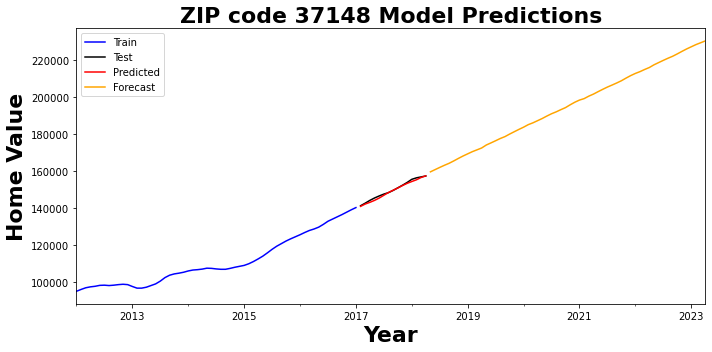

------------ZIP code: 37148 info-------------- 
Year 2018 forcasted home value is: $157400
Year 2023 forcasted home value is: $230502
The mean absolute percentage error of this model is: 0.38%


In [93]:
model_37148, forcast_37148 = plot_function(df,37148, param_37148, .8)

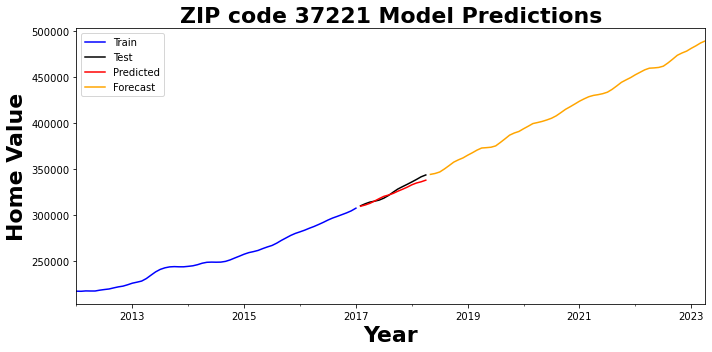

------------ZIP code: 37221 info-------------- 
Year 2018 forcasted home value is: $344000
Year 2023 forcasted home value is: $489648
The mean absolute percentage error of this model is: 0.7%


In [96]:
model_37221, forcast_37221 = plot_function(df,37221, param_37221, .8)

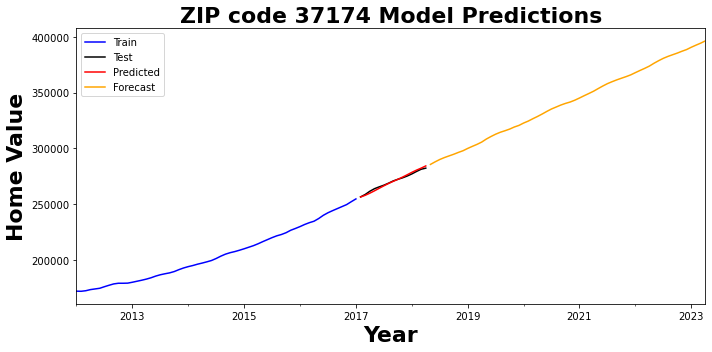

------------ZIP code: 37174 info-------------- 
Year 2018 forcasted home value is: $282200
Year 2023 forcasted home value is: $396244
The mean absolute percentage error of this model is: 0.35%


In [97]:
model_37174, forcast_37174 = plot_function(df,37174, param_37174, .8)

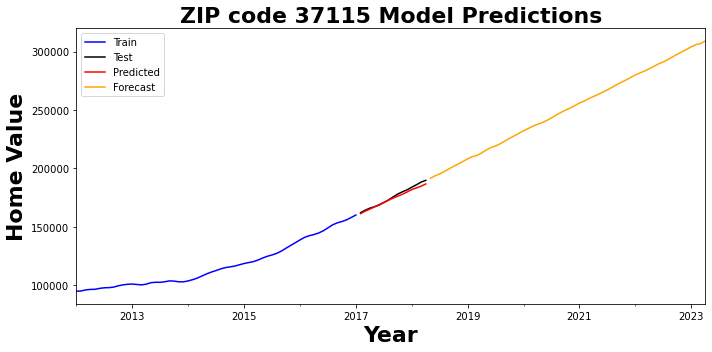

------------ZIP code: 37115 info-------------- 
Year 2018 forcasted home value is: $189800
Year 2023 forcasted home value is: $309160
The mean absolute percentage error of this model is: 0.79%


In [103]:
model_37115, forcast_37115= plot_function(df,37115, param_37115, .8)

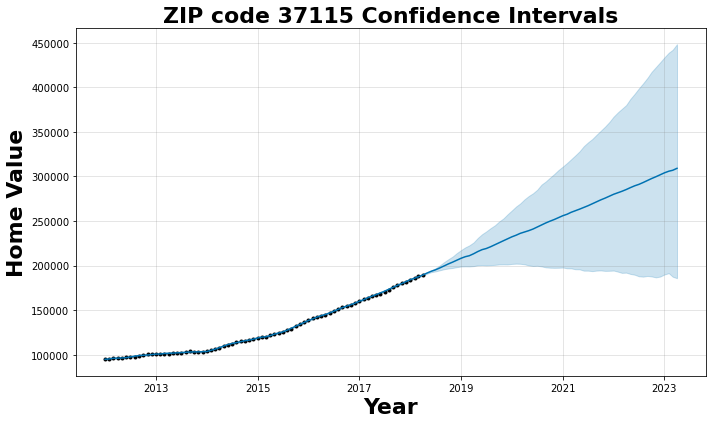

In [111]:
fig1 = model_37115.plot(forcast_37115)
font = {'weight' : 'bold',
            'size'   : 22}
plt.xlabel('Year', fontdict = font)
plt.ylabel('Home Value',fontdict = font)
plt.title('ZIP code 37115 Confidence Intervals', fontdict = font)
plt.tight_layout()
plt.savefig('../report/figures/37115_Confidence', dpi = 300)
plt.show()

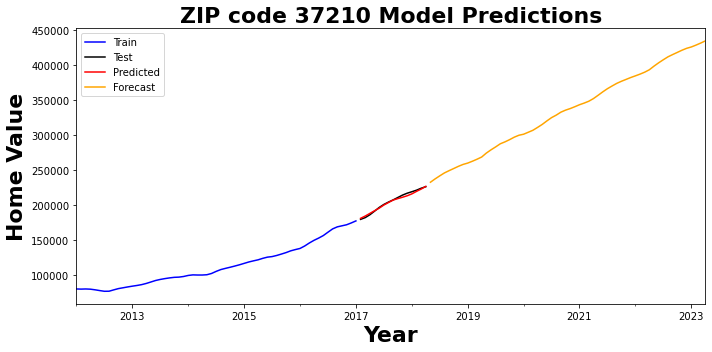

------------ZIP code: 37210 info-------------- 
Year 2018 forecasted home value is: $226500
Year 2023 forecasted home value is: $434484
The mean absolute percentage error of this model is: 0.76%


In [107]:
model_37210, forcast_37210 = plot_function(df,37210, param_37210, .8)